<a href="https://colab.research.google.com/github/tusharsingh3199/ML-Projects/blob/main/MalariaCellDetection(ResNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import kagglehub
import os
import glob
import random
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
path = path + '/cell_images/cell_images'
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cell-images-for-detecting-malaria' dataset.
Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images


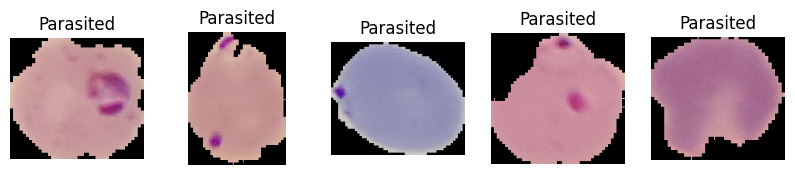

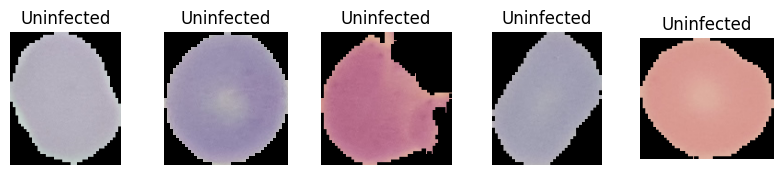

In [3]:
list_dir = os.listdir(path)
Parasitized_dir = glob.glob(os.path.join(path, 'Parasitized', '*'))
Uninfected_dir = glob.glob(os.path.join(path, 'Uninfected', '*'))

Para_len, Uninf_len = len(Parasitized_dir)-1, len(Uninfected_dir)-1

plt.figure(figsize=(10, 10))
for i in range(1,6):
    plt.subplot(5, 5, i)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(plt.imread(Parasitized_dir[random.randint(0, Para_len)]),cmap=plt.cm.binary)
    plt.title("Parasited")

plt.figure(figsize=(10, 10))
for i in range(1,6):
    plt.subplot(5, 5, i)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(plt.imread(Uninfected_dir[random.randint(0, Uninf_len)]),cmap=plt.cm.binary)
    plt.title("Uninfected")


In [27]:
train_ds = tf.keras.utils.image_dataset_from_directory(path, image_size=(224, 224), batch_size=32,
                                          shuffle=True, validation_split=0.2, seed=69, subset="training")

tf.random.set_seed(69)
val_ds = tf.keras.utils.image_dataset_from_directory(path, image_size=(224, 224), batch_size=32,
                                           validation_split=0.2, seed=69, subset="validation")

class_names = train_ds.class_names
print(class_names)

data_augmentation = keras.Sequential([ layers.RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)), layers.RandomRotation(0.3), layers.RandomZoom(0.1),
                                      layers.Resizing(224, 224), layers.RandomBrightness(factor=0.3), layers.RandomGaussianBlur(0.1), layers.RandomContrast(0.3)])

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
['Parasitized', 'Uninfected']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,177,909 (92.23 MB)

 Trainable params: 590,197 (2.25 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

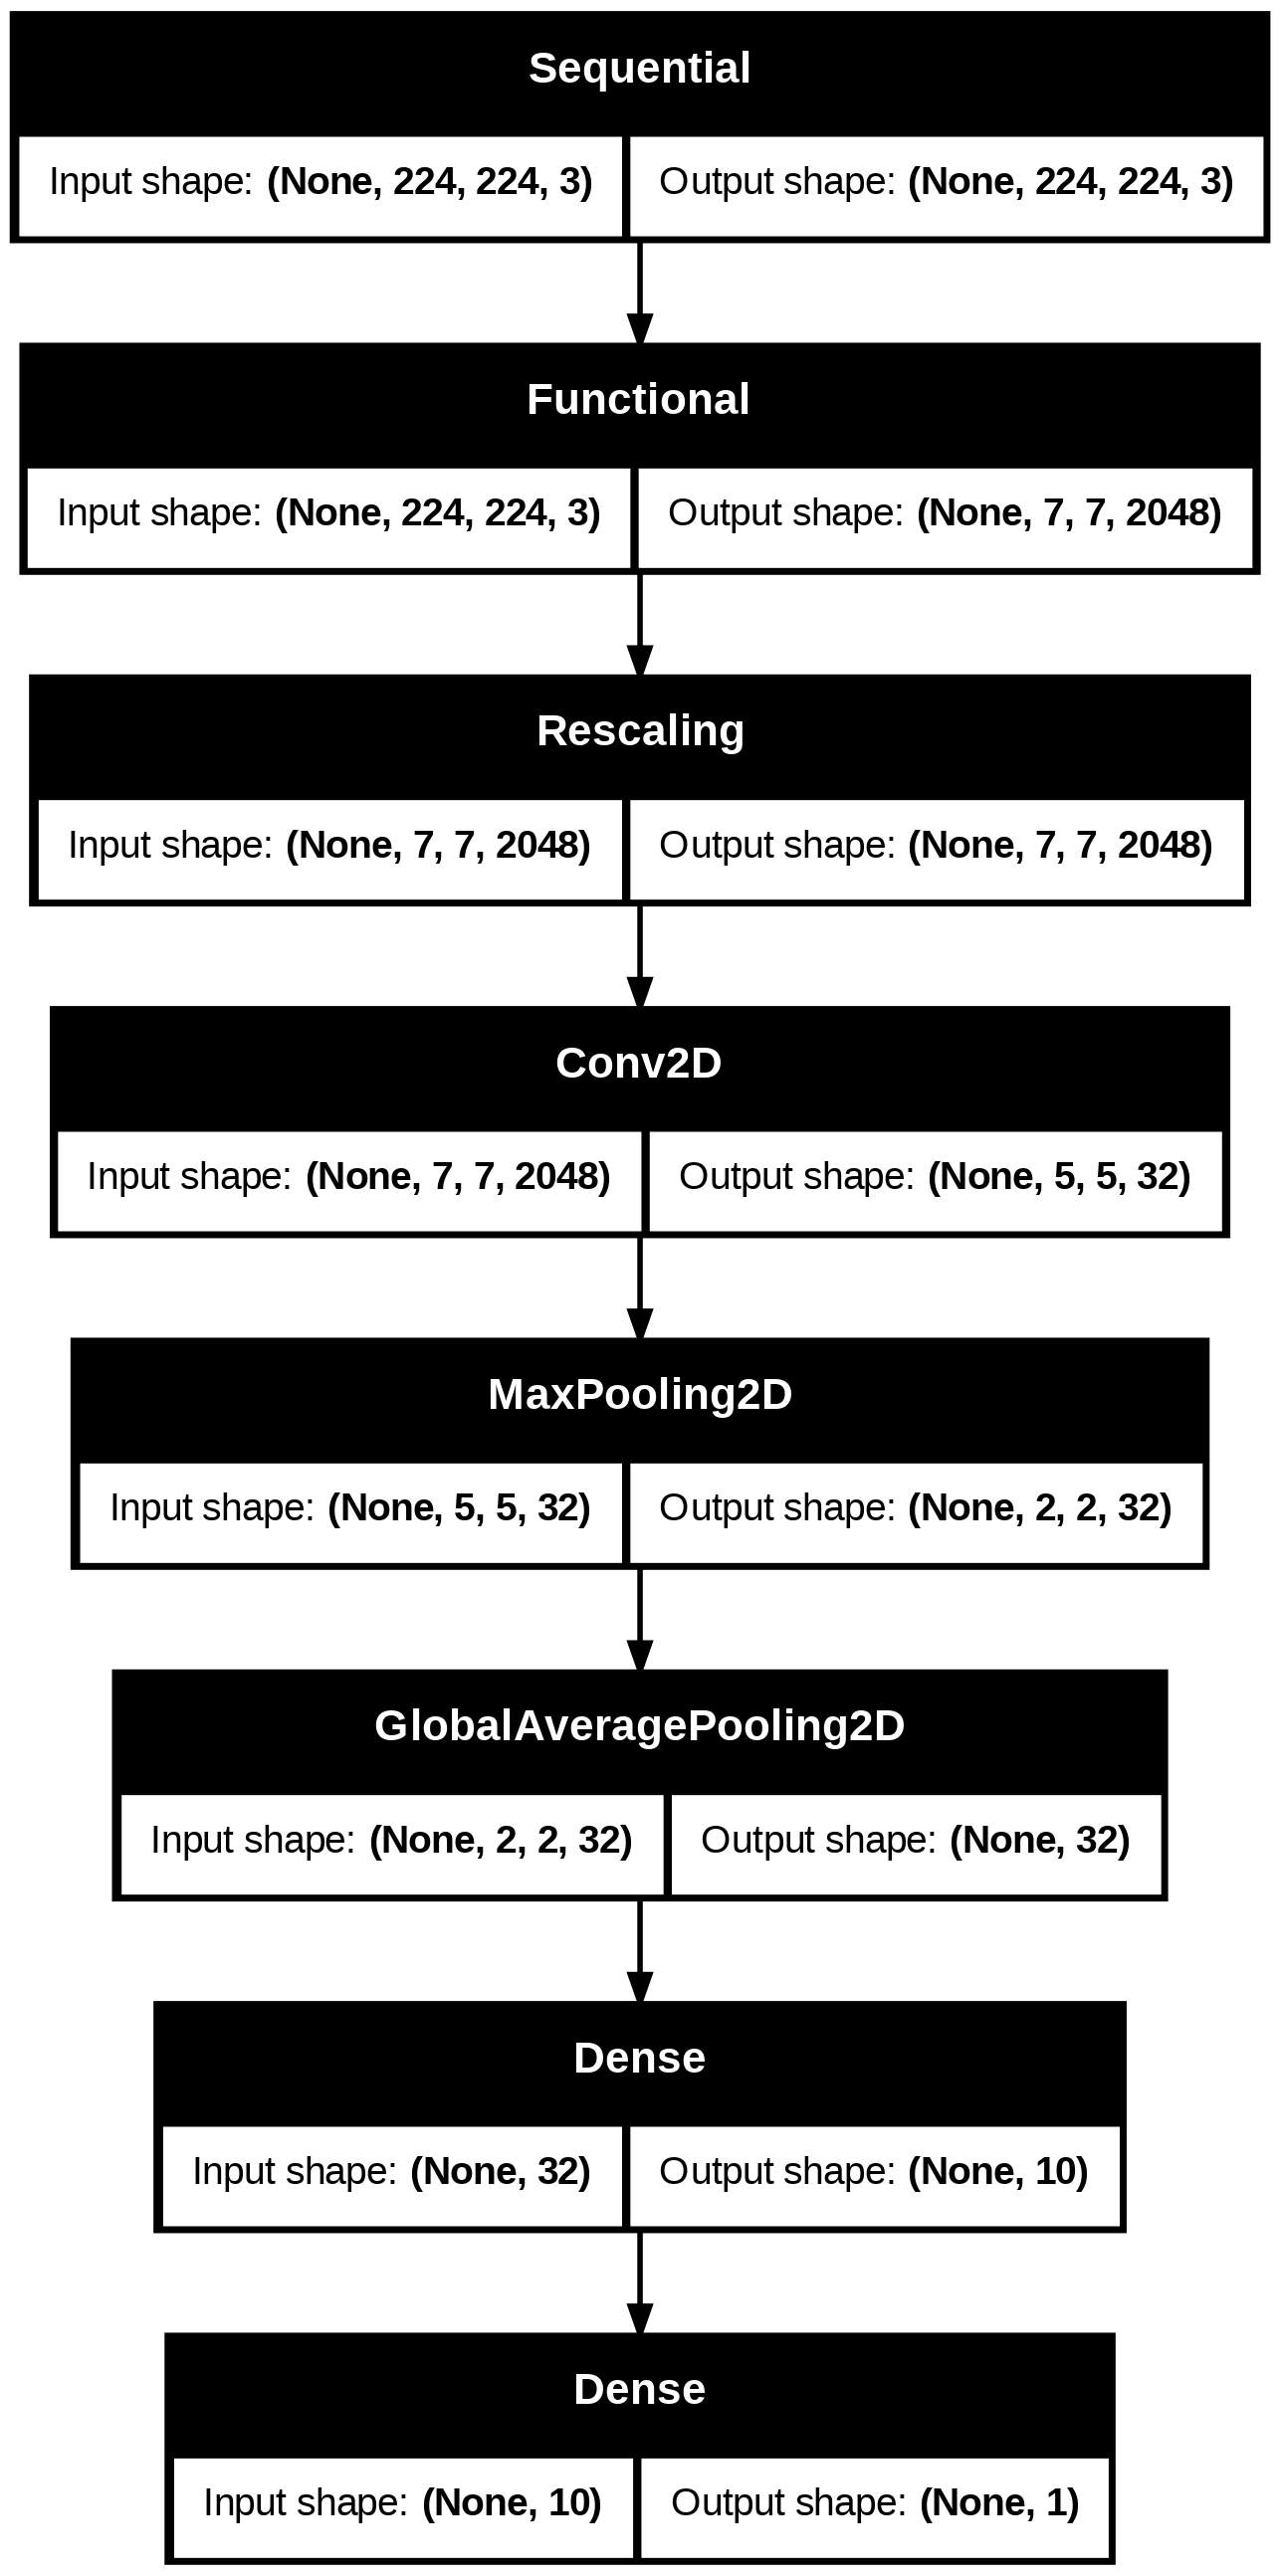

In [30]:
BaseModel = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
BaseModel.trainable = False

ResNet = tf.keras.Sequential([
    data_augmentation,
    BaseModel,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') ])

ResNet.summary()
tf.keras.utils.plot_model(ResNet, show_shapes=True)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 124s 169ms/step - accuracy: 0.8401 - loss: 0.3925 - val_accuracy: 0.9251 - val_loss: 0.1956 - learning_rate: 0.0010
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 139s 165ms/step - accuracy: 0.9196 - loss: 0.2076 - val_accuracy: 0.9318 - val_loss: 0.1770 - learning_rate: 0.0010
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 114s 165ms/step - accuracy: 0.9293 - loss: 0.1854 - val_accuracy: 0.9421 - val_loss: 0.1641 - learning_rate: 0.0010
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 113s 164ms/step - accuracy: 0.9381 - loss: 0.1704 - val_accuracy: 0.9416 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 113s 165ms/step - accuracy: 0.9386 - loss: 0.1636 - val_accuracy: 0.9472 - val_loss: 0.1495 - learning_rate: 0.0010


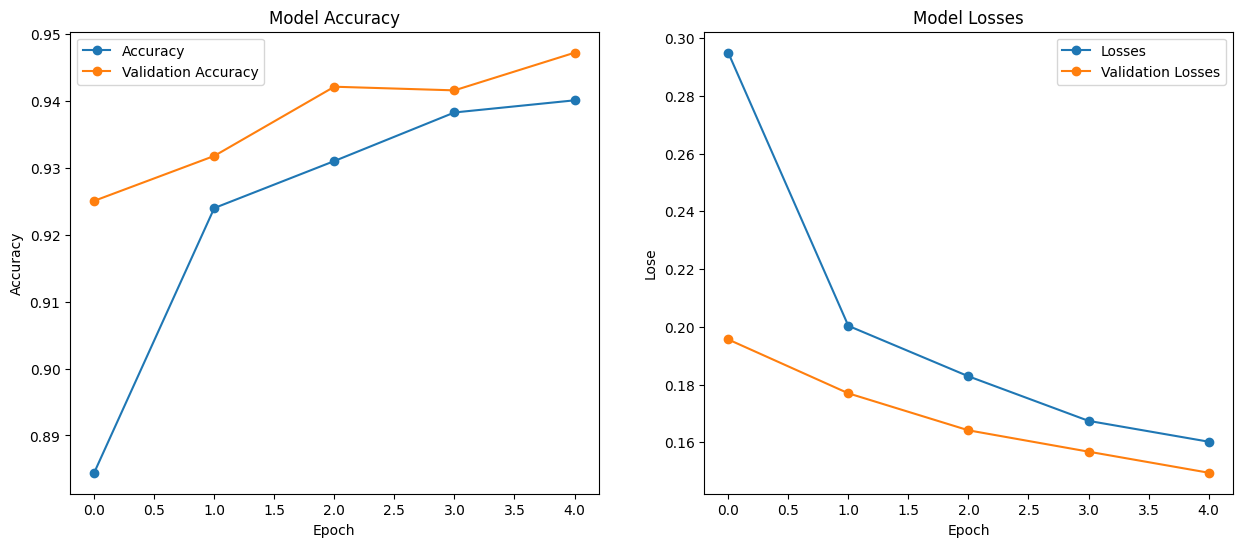

In [31]:
ResNet.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

ModelHistory = ResNet.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

acc = ModelHistory.history['accuracy']
val_acc = ModelHistory.history['val_accuracy']
loss = ModelHistory.history['loss']
val_loss = ModelHistory.history['val_loss']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, marker="o", label="Accuracy", )
plt.plot(val_acc, marker="o", label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, marker="o", label="Losses")
plt.plot(val_loss, marker="o", label="Validation Losses")
plt.title("Model Losses")
plt.ylabel("Lose")
plt.xlabel("Epoch")
plt.legend()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,177,909 (92.23 MB)

 Trainable params: 17,805,685 (67.92 MB)

 Non-trainable params: 6,372,224 (24.31 MB)

Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 186s 251ms/step - accuracy: 0.9416 - loss: 0.1794 - val_accuracy: 0.9603 - val_loss: 0.1449 - learning_rate: 1.0000e-04
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 170s 247ms/step - accuracy: 0.9565 - loss: 0.1291 - val_accuracy: 0.9590 - val_loss: 0.1460 - learning_rate: 1.0000e-04
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 169s 246ms/step - accuracy: 0.9648 - loss: 0.1112 - val_accuracy: 0.9648 - val_loss: 0.1151 - learning_rate: 1.0000e-04
Epoch 9/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 169s 245ms/step - accuracy: 0.9650 - loss: 0.1038 - val_accuracy: 0.9641 - val_loss: 0.1168 - learning_rate: 1.0000e-04
Epoch 10/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 169s 245ms/step - accuracy: 0.9647 - loss: 0.1002 - val_accuracy: 0.9670 - val_loss: 0.0939 - learning_rate: 1.0000e-04


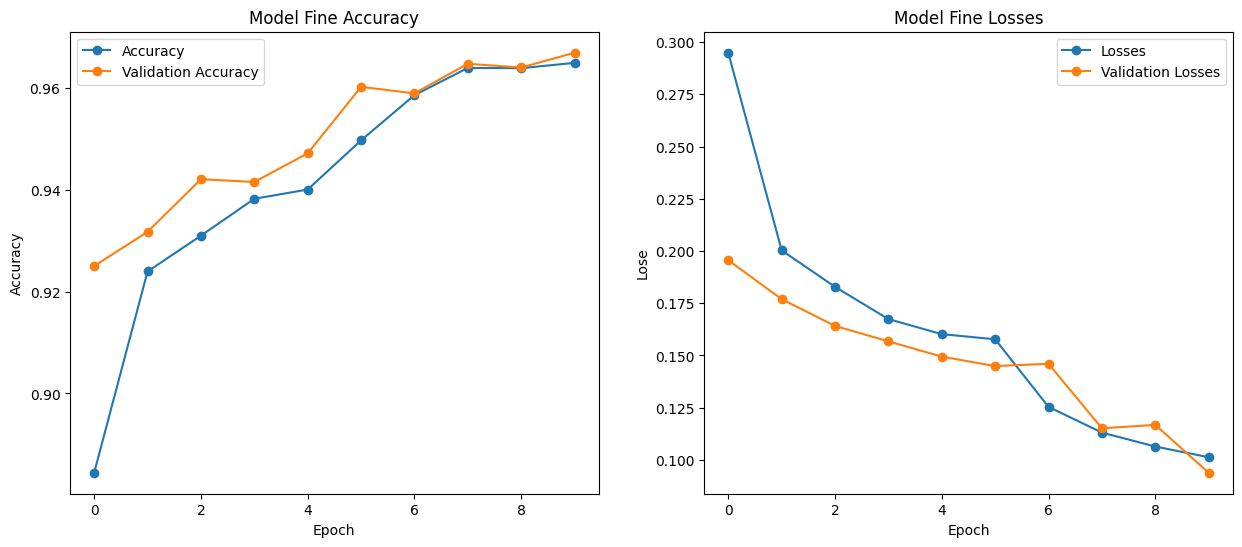

In [32]:
BaseModel.trainable = True
for layer in BaseModel.layers[:120]:
    layer.trainable = False

ResNet.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

ResNet.summary()
ModelFineHistory = ResNet.fit(train_ds, epochs=10, initial_epoch=5, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

acc += ModelFineHistory.history['accuracy']
val_acc += ModelFineHistory.history['val_accuracy']
loss += ModelFineHistory.history['loss']
val_loss += ModelFineHistory.history['val_loss']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, marker="o", label="Accuracy", )
plt.plot(val_acc, marker="o", label="Validation Accuracy")
plt.title("Model Fine Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, marker="o", label="Losses")
plt.plot(val_loss, marker="o", label="Validation Losses")
plt.title("Model Fine Losses")
plt.ylabel("Lose")
plt.xlabel("Epoch")
plt.legend()

Model already exists.... Skip saving... 


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction:  Parasitized 




(np.float64(-0.5), np.float64(153.5), np.float64(135.5), np.float64(-0.5))

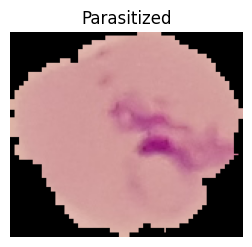

In [33]:
img_dir = Uninfected_dir[random.randint(0, Uninf_len)]
img_dir = Parasitized_dir[random.randint(0, Para_len)]

img = tf.keras.utils.load_img(img_dir, target_size=(224,224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

save_path = "ResNetModel.keras"
if not os.path.exists(save_path):
    ResNet.save(save_path)
    print(f"Model saved at: {save_path}")
else:
    print("Model already exists.... Skip saving... \n\n")

LoadBaseModel = tf.keras.models.load_model(save_path)

prediction = ResNet.predict(img_array)
prediction = 0 if prediction[0][0] < 0.5 else 1

Answer = class_names[prediction]
plt.figure(figsize=(3,3))
print("Prediction: ", Answer, "\n\n")
plt.imshow(plt.imread(img_dir), cmap=plt.cm.binary)
plt.grid(False)
plt.title(Answer)
plt.axis("off")

In [34]:
Loss, Accuracy = ResNet.evaluate(val_ds)
print("Loss: ", Loss, "\nAccuracy: ", Accuracy)

all_true_labels = []
y_prediction = []

for image, labels in val_ds:
    all_true_labels.extend(labels.numpy())
    y_prediction.extend(ResNet.predict(image, verbose=0).round())

y_true = np.array(all_true_labels)
y_prediction = np.array(y_prediction).flatten()

173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9620 - loss: 0.1093
Loss:  0.09388457238674164 
Accuracy:  0.9669751524925232


              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      2723
  Uninfected       0.96      0.98      0.97      2788

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



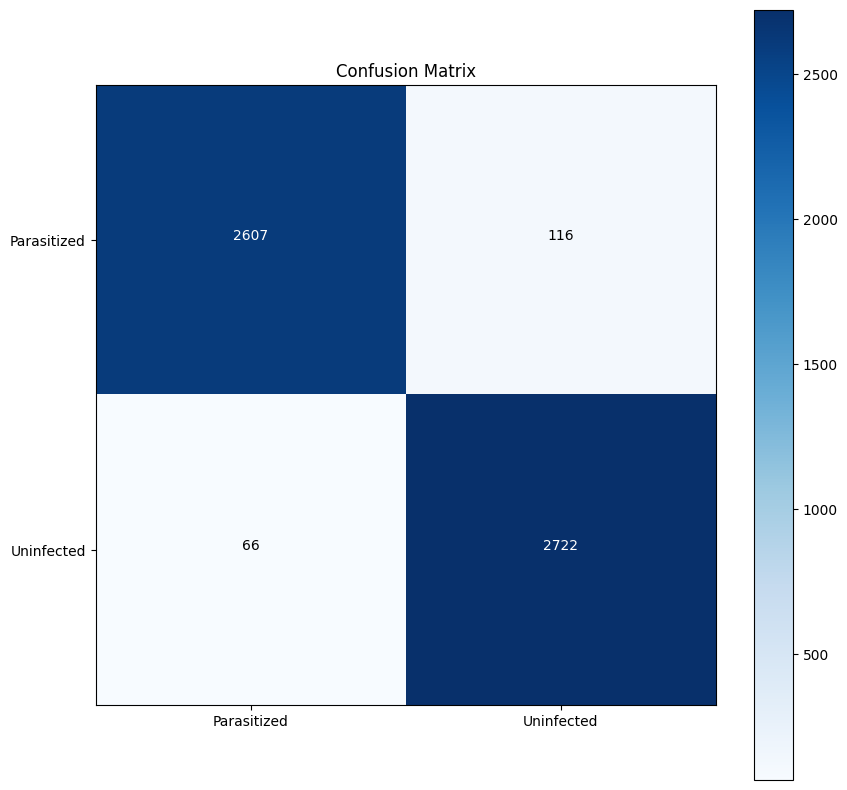

In [35]:
cm = confusion_matrix(y_true, y_prediction)
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = class_names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
print(classification_report(y_true, y_prediction, target_names= classes ))